# Numerical implementation of the sensitivity analysis performed in L. Darrigade and al 

We present here the numerical implementation to produce results of sect 6.2. This part aim at producing a sensitivity analysis (SA) using the global method of the Elementary Effects (EE) of Morris [(Morris 1991)](https://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804) .

We recal that Morris method estimate different sensitivity index such as mean $\mu$, standard deviation $\sigma$ and mean of absolute values of Elementary effects for each studied parameter. These indices are used to interpret the effect of a parameter on an output. See cell References for more informations. 

Also we warn that this notebook cannot work without the SAFE library download. This library is open source but requires permission to use from these authors see :  https://www.safetoolbox.info/ for more informations. 


User are able to run part Display whitout the use of SAFE Toolbox. This last part allows to obtain the graphs presented in the article 

In [1]:
# Load libraries
import numpy as np
import time
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

#load modules 
import util as ut
import module_SA as SA
import module_model_resolution as reso

### Definition of biological  parameters and the parameters used to perform SA

Biological parameter values are listed in Tab 12/13 from ref L. Darrigade and all. To carry out the analysis we vary the parameters over a range of 50\% of their value except for $W$ which varies at 30\%. 

In [2]:
# Biological parameters 
dict_param = {
    # Geometry
    "Z_max": 200.0,
    "r0": 25.0,
    "eps": 2.5,
    #
    # mecanic interaction
    "W_barre": 6.01 / 8,
    "D_barre": 12.07,
    #
    # sc division
    "q_div_sc": 0.15,
    "K_div_sc": 12.0,
    "l_div_sc": 5.0,
    "K_cont_div_sc": 53.0,
    "l_cont_div_sc": 6.0,
    "K_but_sc": 2,
    "l_but": 5,
    # Differenctiation sc - pc
    "q_sc_pc": 0.2,
    #
    # pc division
    "q_div_pc": 0.22,
    "K_div_pc": 40.0,
    "l_div_pc": 40.0,
    "K_cont_div_pc": 41.0,
    #
    # # Differenciation pc - ent / gc
    "q_pc_gc": 0.25 / 3,
    "q_pc_ent": 0.25,
    "l_pc_ent": 15.0,
    #
    "K_but_pc_dif": 1.5,
    # Extrusion
    "q_ex": 0.34,
    "K_ext": 190.0,
    "l_ext": 15.0,
    "K_cont_ext": 20.0,
    #
    # Boundary condition for densities
    "cond_sc_z0": 0.65,
    "cond_pc_z0": 0,
    "cond_gc_z0": 0,
    "cond_ent_z0": 0,
    #
    # Initial state for DCS cells
    "dcs_zd": 3,
    "dcs_d": 2.25,
    "dcs_zu": 3,
    "dcs_u": -1 / 8,
    "nb_dcs": 12,
    #
    # # Metabolites concentrations
    "sigma_b": 3.6e6,
    "sigma_o": 3.6e6,
    "gamma": 1.6e4 / 15.5,
    "K_b_o": 0.184 * 10 ** 4,
    "c_b_top": 5,
    "c_o_bot": 10,
}

# selected parameters with their value and range of variation
dict_param_SA = {
    "W_barre": [6.01 / 8, 30],  
    "q_div_sc": [0.15, 50],
    "K_div_sc": [12, 50],
    "l_div_sc": [5, 50],
    "K_cont_div_sc": [53, 50],
    "l_cont_div_sc": [6, 50],
    "K_but_sc": [2, 50],
    "l_but": [5, 50],
    "q_sc_pc": [0.2, 50],
    "q_div_pc": [0.22, 50],
    "K_div_pc": [40, 50],
    "l_div_pc": [40, 50],
    "K_cont_div_pc": [41, 50],
    "q_pc_ent": [0.25, 50],
    "l_pc_ent": [15, 50],
    "K_but_pc_dif": [1.5, 50],
    "q_ex": [0.34, 50],
    "K_ext": [190, 50],
    "l_ext": [15, 50],
    "K_cont_ext": [20, 50],
    "sigma_o": [3.6e6, 50],
    "gamma": [1.6e4 / 15.5, 50],  
    "K_b_o": [0.184 * 10 ** 4, 50],
    "c_b_top": [5, 50],
    "c_o_bot": [10, 50],
    "cond_sc_z0": [0.65, 50],  
}


### Definition of umerical parameters and space-dependant variable

We recal that $\phi(z)$ allows to take into account the impact of curvature on the top and at the bottom of the crypte on the interaction force, its value is given by  :

\begin{equation}
\label{eq:phi}
\mathcal{\phi}(z):=\begin{cases}
\frac{\frac{f(z)}{r_0}-\frac{f(0)}{r_0}}{1-\frac{f(0)}{r_0}}\quad &\text{ if }z\leq r_0-\epsilon\\
1 \quad &\text{ if }r_0-\epsilon<z<z_{max}-r_0+\epsilon\\
\frac{\frac{f(z_{max})}{r_0}-\frac{f(z)}{r_0}}{\frac{f(z_{max})}{r_0}-1}\quad &\text{ if }z\geq z_{max}-r_0+\epsilon
\end{cases}
\end{equation}

with $f(z)$ the crypt form :

\begin{equation}\label{eq:def_f}
f(z)=\begin{cases}
r_0\sqrt{\frac{z+\epsilon}{r_0}\left(2-\frac{z+\epsilon}{r_0}\right)}\quad &\text{ if }z\leq r_0-\epsilon\\
r_0 \quad &\text{ if }r_0-\epsilon<z<z_{max}-r_0+\epsilon\\
r_0\left(2-\sqrt{\frac{z_{max}-z+\epsilon}{r_0}\left(2-\frac{z_{max}-z+\epsilon}{r_0}\right)}\right)\quad &\text{ if }z\geq z_{max}-r_0+\epsilon
\end{cases}
\end{equation}

In the implementation of the resolution we supposed the existence of a correction term to take into acount the impact of curvature on the local density of cells : $C(z)$. This would give $G(z) = \frac{W \phi(z) C(z)}{2}$. 
In the article (\bold{REF} )this approach is not explored so we assume here that C(z) = 1.

concerning space regulation term of cell fat events we use the piecewise polynomial function $R(y,K,l)$ such as : 

\begin{equation}
R(y,K,\ell) :=
\label{form:regul}
\begin{cases}
0 & \text{if } y \leq K - \ell,\\
-\frac{1}{4\ell^3}y^3 + \frac{3K}{4\ell^3}y^2 - \frac{3K^2 - 3\ell^2}{4l^3} y + \frac{K^3 + 2\ell^3 - 3 K\ell^2}{4\ell^3}     & \text{if } K - \ell \leq  y \leq K + \ell,\\
1  & \text{if } K + \ell \geq y.
\end{cases}
\end{equation}

Several regulations are not time-dependent but only space-dependent, as in the case of Wnt regulations (see table 1)(\bold{REF})

Space variables are stored in a dictionary : dict_space. 

In [15]:
# Definition of numeric parameters 
dict_num = {
    "nz": 400,  # Number of vertices
    "Tmax": 4000,  # maximal time
    "dt": 0.00025,  # initial time step
    "nout": 20000,  # used for the stop criterion of the resolution loop and display
}

# Space step :
dict_num["dz"] = dict_param["Z_max"] / (dict_num["nz"] + 1)

# kinetic diffusif explicit scheme parameters :
dict_num["alpha"] = 0.9  
dict_num["a_m1"] = 0.0 
dict_num["a_0"] = 1  
dict_num["a_1"] = 0.0  
dict_num["a_2"] = 0.0  
dict_num["m"] = (-dict_num["a_2"] + dict_num["a_m1"]) / (
    dict_num["a_0"]
    - dict_num["a_1"]
    - 3 * dict_num["a_2"]
    + 3 * dict_num["a_m1"]
)


# Vector of space vertices
zn = np.linspace(0, dict_param["Z_max"], dict_num["nz"] + 1)

# Definition of space variable stored in the dictionnary dict_space
dict_space = {
    
    "phi": np.array(
        [
            reso.Get_phi(z, dict_param["Z_max"], dict_param["r0"], dict_param["eps"])
            for z in zn
        ]
    ),
    "phi_prime": np.array(
        [
            reso.Get_phi_prime(z, dict_param["Z_max"], dict_param["r0"], dict_param["eps"])
            for z in zn
        ]
    ),
    "phi_second": np.array(
        [
            reso.Get_phi_second(z, dict_param["Z_max"], dict_param["r0"], dict_param["eps"])
            for z in zn
        ]
    ),

    "C": np.ones(dict_num["nz"] + 1),
    "C_prime": np.zeros(dict_num["nz"] + 1),
    "C_second": np.zeros(dict_num["nz"] + 1),
}

dict_space["G"] = reso.Get_G(dict_space["C"], dict_space["phi"], dict_param["W_barre"])

dict_space["G_prime"] = reso.Get_G_prime(
    dict_space["C"],
    dict_space["C_prime"],
    dict_space["phi"],
    dict_space["phi_prime"],
    dict_param["W_barre"],
)

dict_space["G_second"] = reso.Get_G_second(
    dict_space["C"],
    dict_space["C_prime"],
    dict_space["C_second"],
    dict_space["phi"],
    dict_space["phi_prime"],
    dict_space["phi_second"],
    dict_param["W_barre"],
)

# Regulation function from source terms 
dict_space["R_sc"] = reso.regulation_r(zn, dict_param["K_div_sc"], dict_param["l_div_sc"])
dict_space["R_pc"] = reso.regulation_r(zn, dict_param["K_div_pc"], dict_param["l_div_pc"])
dict_space["R_pc_gc_ent"] = reso.regulation_r(zn, dict_param["K_div_pc"], dict_param["l_pc_ent"])
dict_space["R_ext"] = reso.regulation_r(zn, dict_param["K_ext"], dict_param["l_ext"])


dict_space['z_coord'] = zn 

### Initialisations
We start from an empty crypt : $\rho_{l,0} = 0 \forall l \in \{'sc', 'pc', 'gc','ent'\}$ and from a DCS cell density following the shape : 


\begin{equation}
\label{eq:dcs_shape}
\rho_{dcs}(z) = \frac{N_{dcs}}{\int_{0}^{Z_{max}}\bar{\rho}_{dcs}(z) dz}\bar{\rho}_{dcs}(z)
\end{equation}	
with

\begin{equation*} 	
\bar{\rho}_{dcs}(z) = 
\begin{cases}  
d (z-z_d) + 1  & \mbox{if} \;  z_d - \frac{1}{d} < z < z_d, \\
1 & \mbox{if} \; z_d \leq z \leq z_u, \\
1+ u(z - z_u) & \mbox{if}\; z_u < z < z_u - \frac{1}{u},\\
0 &\mbox{otherwise,}
\end{cases}
\end{equation*}

where $ z_{d}, d>0 , z_{u}, u<0$ and $N_{dcs}$ is the predefined number of DCS cells. 

We also set initial concentration of butyrate and $O_2$ at zero. 

In [16]:
# Initial conditions for densities
dcs_dens = np.array(
    [
        reso.dcs_shape(
            z,
            dict_param["dcs_zd"],
            dict_param["dcs_d"],
            dict_param["dcs_zu"],
            dict_param["dcs_u"],
        )
        for z in zn
    ]
)


rho_dcs_0 = (dict_param["nb_dcs"] / reso.simps(dcs_dens, zn)) * dcs_dens
rho_sc_0 = rho_pc_0 = rho_gc_0 = rho_ent_0 = np.zeros(dict_num["nz"] + 1)

# Initial conditions for concentrations
c_o = c_b =  np.zeros(dict_num["nz"] + 1)

# Resolution variable 
y0 = [rho_sc_0, rho_dcs_0, rho_pc_0, rho_gc_0, rho_ent_0, c_o, c_b]

### SA settings 

In the following cells two example are presented. The first one is a sensitivity analysis on 2 parameters, easy to run. It allows to see how it is possible to perform sensitivty analysis. The second example is the one proposed to obtain results presented in L. Darrigade and all. 

In [17]:
# Simple example - test 

R = 2 # number of trajectories 
nb_opt_traj = 0 # Option proposed by SALib based on Campolongo and al 2007 paper 
                # to optimize the parameter space exploration
dict_param_SA = {"q_div_sc": [0.22, 50], "q_ex": [0.34, 50]} # overwright dict_param_SA for the test 
name_latex = np.array(["$q_{div,sc}^\infty$", "$q_{ext}^\infty$"]) # overwright name_latex for the test
saving_file = (
    "backup_SA/R_" + str(R) + "_opt_traj_" + str(nb_opt_traj) + "_SAVE_X_Y_TEST.txt"
) # to store model simulations for every point for each trajectory



# Real settings 
"""
R = 600
nb_opt_traj = 0
name_latex = ut.name_latex, 
saving_file = (
    "backup_SA/R_" + str(R) + "_opt_traj_" + str(nb_opt_traj) + "_SAVE_X_Y_notebook.txt"
)
"""

'\nR = 600\nnb_opt_traj = 0\nname_latex = ut.name_latex, \nsaving_file = (\n    "backup_SA/R_" + str(R) + "_opt_traj_" + str(nb_opt_traj) + "_SAVE_X_Y_notebook.txt"\n)\n'

### Outputs generation 

Using SALib library. Results are saved in the file : saving_file. Be carefull the simple example will run in a few minutes however real settings have been ran on 90 CPU for a duration of 24h in our case.

In [18]:
start_time = time.time()

dict_SA = SA.SA_generate_Y_from_X(
    saving_file,
    R,
    dict_param_SA,
    y0,
    dict_param,
    dict_num,
    dict_space,
    name_latex,
    nb_optimal_traj=nb_opt_traj,
    nb_CPU=3,
)

print("Time : ", time.time() - start_time)

/home/mhaghebaert/Bureau/Hote_Microb_Interaction_codes/module_model_resolution.py:136: RuntimeWarning: divide by zero encountered in double_scalars
  np.max(np.abs(y_sol[i] - y_nout[i])) / np.max(np.abs(y_nout[i]))
/home/mhaghebaert/Bureau/Hote_Microb_Interaction_codes/module_model_resolution.py:136: RuntimeWarning: divide by zero encountered in double_scalars
  np.max(np.abs(y_sol[i] - y_nout[i])) / np.max(np.abs(y_nout[i]))
/home/mhaghebaert/Bureau/Hote_Microb_Interaction_codes/module_model_resolution.py:136: RuntimeWarning: divide by zero encountered in double_scalars
  np.max(np.abs(y_sol[i] - y_nout[i])) / np.max(np.abs(y_nout[i]))


Time :  246.55955362319946


### Analysis of results 

Using SAFE library. We recal that users have to ask for permission to download this library see :  https://www.safetoolbox.info/ for more informations. 
Function use_SAFE_indices_and_convergence return a dictionary with mu,mu_star,sigma values get with Morris SA and indices convergence (ranking, screening, indices


Blabla sur article pour les critères de convergence 

In [1]:
### Be carefull this cell might take time (env 5 mins)
start_time = time.time()

 
with open(saving_file, "rb") as file:
    dict_X_Y = pickle.load(file)


xmin = list(dict_X_Y["problem"]["bounds"][:, 0])
xmax = list(dict_X_Y["problem"]["bounds"][:, 1])
M = len(xmin)

for outputs in dict_X_Y["output_names"]:
    print(outputs)

    dict_X_Y[outputs + "_SA_indices"], dict_X_Y[outputs + "_convergence"] = SA.use_SAFE_indices_and_convergence(
        dict_X_Y["R"],
        xmin,
        xmax,
        dict_X_Y["X"],
        dict_X_Y[outputs],
        dict_X_Y["design_type"],
        Nboot=1000,
        screening_threshold=0.05,
    )

print(time.time() - start_time)

saving_file_notebook = "backup_SA/resultats_article_JOMB_notebook.txt"
with open(saving_file_notebook, "wb") as file:
    pickle.dump(dict_X_Y, file)

NameError: name 'time' is not defined

# Display results
Here you can load results of SA performing for the article L. Darrigade and all, or you can load results get in this notebook. 

#### Display indices and convergence graphes
On indicies graphe we represent the standard deviation $\sigma$ of EEs against the mean of absolute $\mu^*$ values of EEs. Parameters are listed in order of influence (circle: increasing effect ; square:  decreasing effects according to the mean $\mu$ values of EEs). Moreover we represent the criteria convergence with a threshold represented by the dashed lines. We recall that convergences are obtained if the ranking index is below 1 and screening below 0.05 based on the work of (Sarrazin, F., Pianosi, F., & Wagener, T. (2016)). In order to make the convergences visibly comparable, the ranking index is multiplied by 0.05 to share the same threshold as the screening index.


***********  Y_density ************


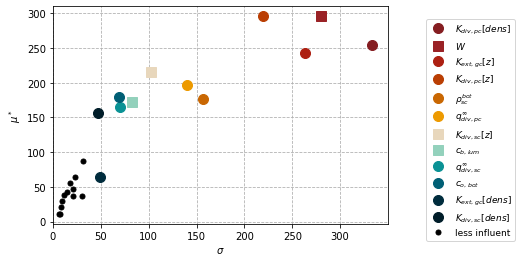

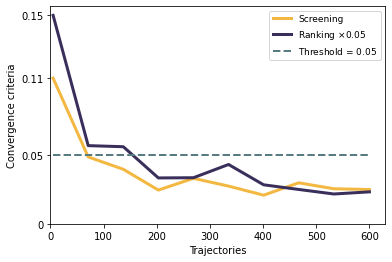

***********  Y_sc_density ************


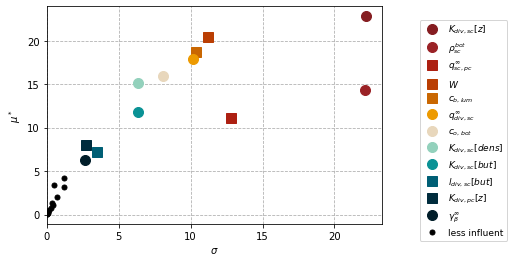

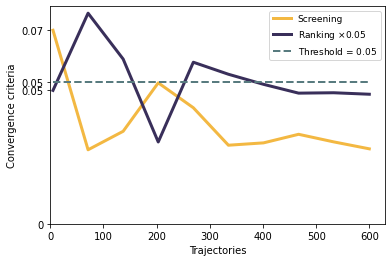

***********  Y_pc_density ************


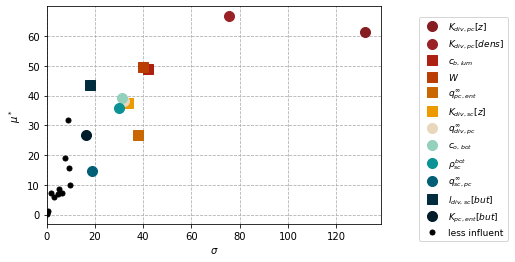

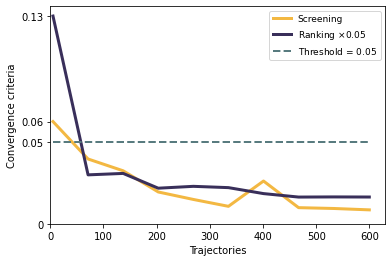

***********  Y_gc_density ************


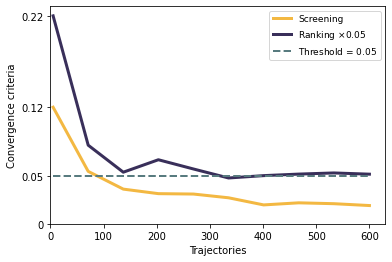

***********  Y_ent_density ************


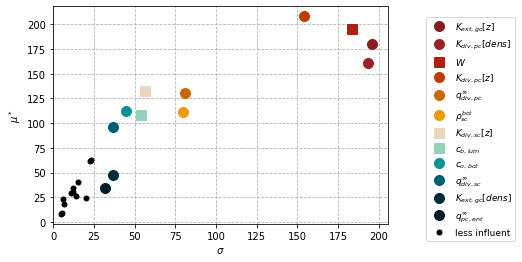

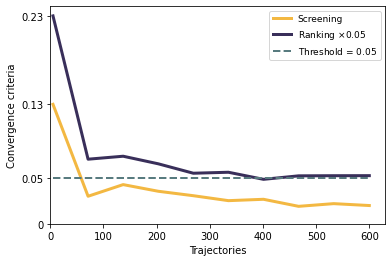

***********  Y_sc_medium_pos ************


***********  Y_pc_medium_pos ************


***********  Y_gc_medium_pos ************


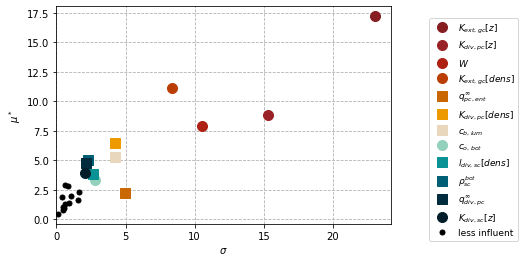

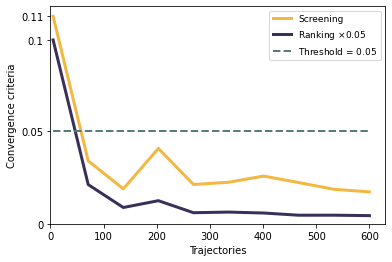

***********  Y_ent_medium_pos ************


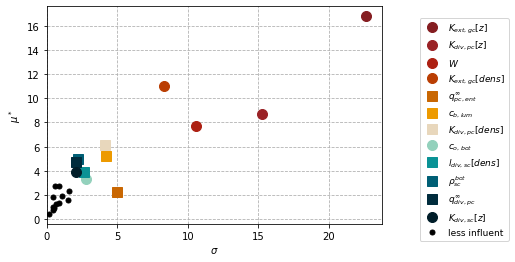

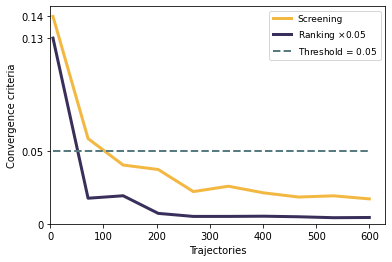

***********  Y_Z_top_o ************


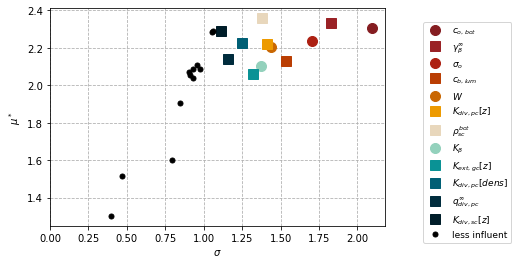

***********  Y_Z_bot_b ************


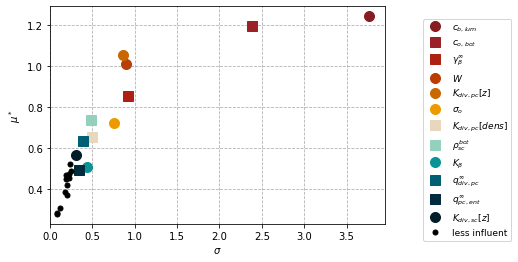

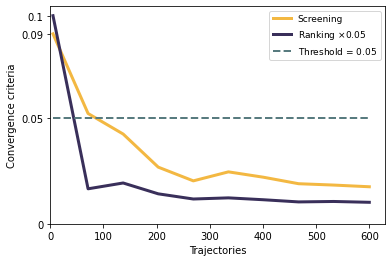

***********  Y_ratio_O_bot_top ************


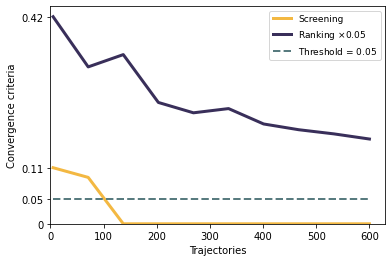

***********  Y_div_rate_sc ************


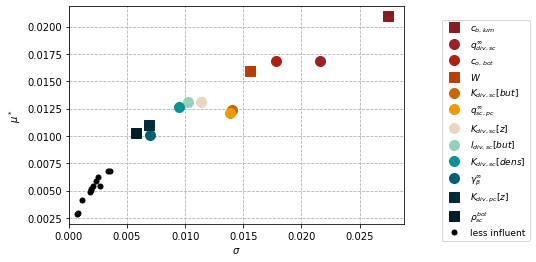

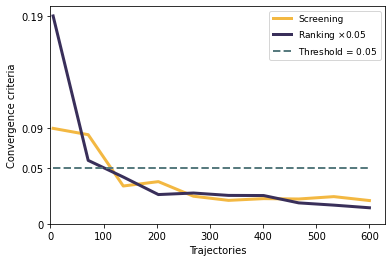

***********  Y_div_rate_pc ************


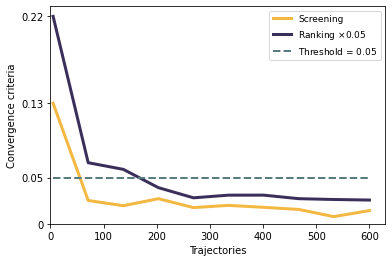

***********  Y_dif_rate_sc_pc ************


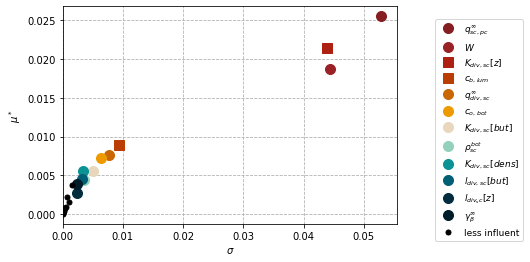

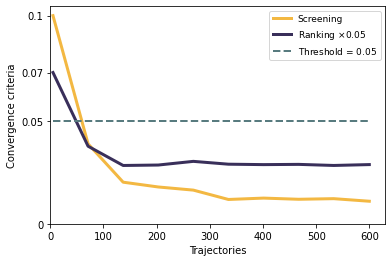

***********  Y_dif_rate_pc_gc ************


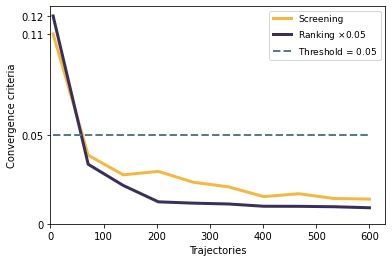

***********  Y_dif_rate_pc_ent ************


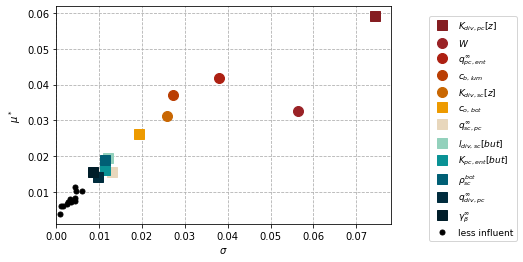

***********  Y_ex_rate_gc ************


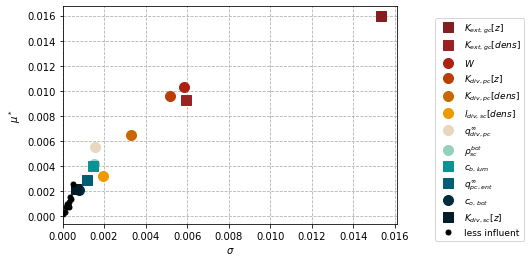

***********  Y_ex_rate_ent ************


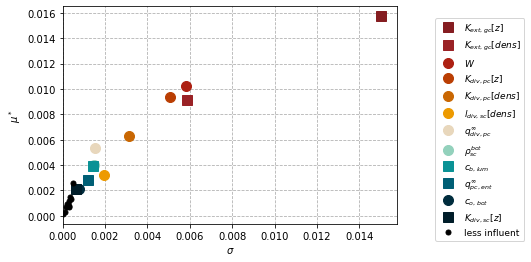

***********  Y_ratio_pc_tot ************


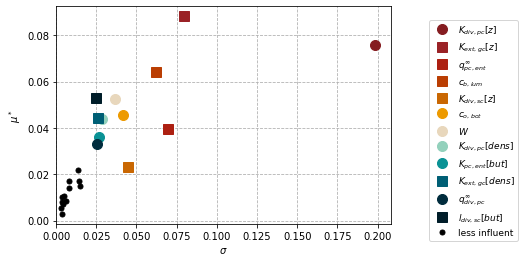

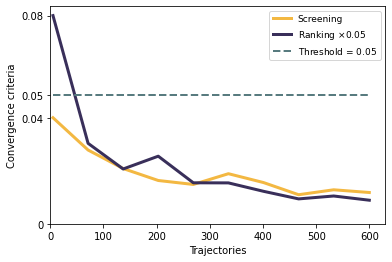

In [3]:
NOTEBOOK = False
if NOTEBOOK : 
    # Load results get in this notebook 
    with open(saving_file_notebook, "rb") as file:
        dict_SA = pickle.load(file)
else : 
    # Load results presented in L. Darrigade and all 
    with open("backup_SA/resultats_article_JOMB.txt", "rb") as file:
        dict_SA = pickle.load(file)

for outputs in dict_SA["output_names"]:

# Plot results in the plane (mean(EE), std(EE)): SAFE function 
    print("*********** ", outputs, "************")
    
    SA.plot_sigma_mu_star(
        dict_SA[outputs + "_SA_indices"]["mu"], 
        dict_SA[outputs + "_SA_indices"]["mu_star"], 
        dict_SA[outputs + "_SA_indices"]["sigma"], 
        list(dict_SA["name_latex"]), 
        colors=ut.color_SA_12_rgb,
    )
    
    
    # Plot convergence
    SA.display_ind_convergence(
        dict_SA[outputs + "_convergence"]["rr"],
        dict_SA[outputs + "_convergence"]["stat_screening"],
        dict_SA[outputs + "_convergence"]["stat_ranking"],
        ut.conv,
  
    )
    


#### display Heat map 

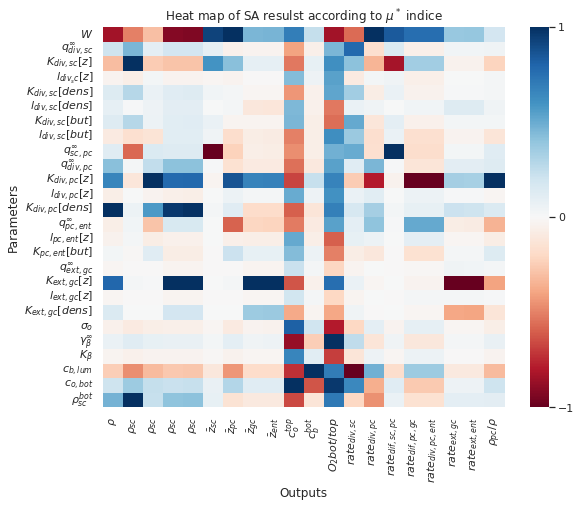

1

In [9]:
NOTEBOOK = False
if NOTEBOOK : 
    # Load results get in this notebook 
    with open(saving_file_notebook, "rb") as file:
        dict_SA = pickle.load(file)
else : 
    # Load results presented in L. Darrigade and all 
    with open("backup_SA/resultats_article_JOMB.txt", "rb") as file:
        dict_SA = pickle.load(file)

SA.heat_map(
    dict_SA,
    output_name=ut.output_name_latex,
    input_name=list(dict_SA['name_latex']),
    title = "Heat map of SA resulst according to $\\mu^*$ indice",
)

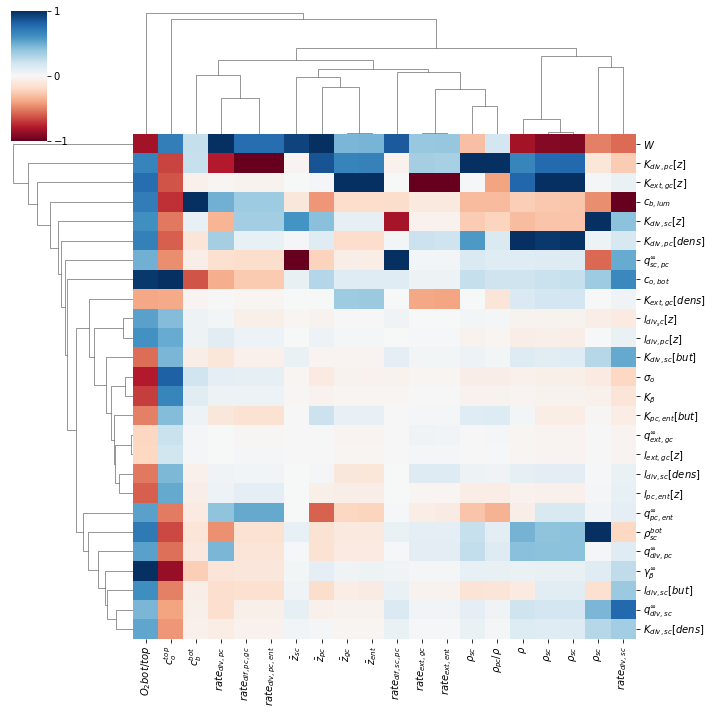

In [3]:
# Heat map with a clustering to group influent and non-influent parameters according to the set of outputs. 
ax = sns.clustermap(
    heat_map.T,
    center=0,
    cbar_kws={"ticks": [-1, 0, 1]},
    cmap="RdBu",
    xticklabels=ut.output_name_latex,
    yticklabels=dict_SA['name_latex'],
)

## References 

Campolongo, F., Cariboni, J., & Saltelli, A. (2007). An effective screening design for sensitivity analysis of large models. Environmental modelling & software, 22(10), 1509-1518. [(Campolongo & all (2007))](https://doi.org/10.1016/j.envsoft.2006.10.004 )  

Morris, M. D. (1991). Factorial sampling plans for preliminary computational experiments. Technometrics, 33(2), 161-174. [(Morris 1991)](https://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804) 

Pianosi, F., Sarrazin, F., & Wagener, T. (2015). A Matlab toolbox for global sensitivity analysis. Environmental Modelling & Software, 70, 80-85. [(SAFE (2015))](https://doi.org/10.1016/j.envsoft.2015.04.009 )   

Sarrazin, F., Pianosi, F., & Wagener, T. (2016). Global Sensitivity Analysis of environmental models: Convergence and validation. Environmental Modelling & Software, 79, 135-152. [(Sarrazin & all (2016))](https://doi.org/10.1016/j.envsoft.2016.02.005)   


Herman, J. and Usher, W. (2017) SALib: An open-source Python library for sensitivity analysis. Journal of Open Source Software, 2(9). [(SALib (2016))](https://joss.theoj.org/papers/10.21105/joss.00097)   

Awad, M., Kiesse, T. S., Assaghir, Z., & Ventura, A. (2019). Convergence of sensitivity analysis methods for evaluating combined influences of model inputs. Reliability Engineering & System Safety, 189, 109-122.[(Awad & all(2019))](https://doi.org/10.1016/j.ress.2019.03.050) 


Léo Darrigade. Modélisation du dialogue hôte-microbiote au voisinage de l’épithélium de l'intestin distal. Probabilités [math.PR]. Université Paris-Saclay, 2020. Français. ⟨NNT : 2020UPASM008⟩. ⟨tel-03145857⟩ [(L. Darrigade (2020))](https://tel.archives-ouvertes.fr/tel-03145857)